load libraries

In [31]:
import os
import cv2
import glob
import numpy as np
import pandas as pd

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

In [32]:
dir = "/ext/Data/distracted_driver_detection/"

model_image_size = 224

def lambda_func(x):
    x /= 255.
    x -= 0.5
    x *= 2
    return x

# 加载数据集

load train data

In [37]:
train_gen = ImageDataGenerator(
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
)
gen = ImageDataGenerator()

batch_size = 128
train_generator = train_gen.flow_from_directory(os.path.join(dir, 'train'), (model_image_size, model_image_size),shuffle=True, batch_size=batch_size, class_mode="categorical")
print("subdior to train type {}".format(train_generator.class_indices))
valid_generator = gen.flow_from_directory(os.path.join(dir, 'valid'), (model_image_size, model_image_size), shuffle=True, batch_size=batch_size, class_mode="categorical")
print("subdior to valid type {}".format(valid_generator.class_indices))

Found 20787 images belonging to 10 classes.
subdior to train type {'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}
Found 1637 images belonging to 10 classes.
subdior to valid type {'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}


# 构建模型

https://github.com/fchollet/keras/blob/master/keras/applications/resnet50.py


In [38]:
input_tensor = Input((model_image_size, model_image_size, 3))
x = input_tensor
if lambda_func:
    x = Lambda(lambda_func)(x)

base_model = ResNet50(input_tensor=Input((model_image_size, model_image_size, 3)), weights='imagenet', include_top=False)

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(10, activation='softmax')(x)
model = Model(base_model.input, x)

print("total layer count {}".format(len(base_model.layers)))

for i in range(140):
    model.layers[i].trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

total layer count 174


# 训练模型

In [ ]:
steps_train_sample = 20787 // 128
steps_valid_sample = 1637 // 128

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_train_sample, epochs=8, validation_data=valid_generator, validation_steps=steps_valid_sample)

model.save("models/resnet50-imagenet-finetune140.h5")
print("model saved!")

Epoch 1/8
162/162 [==============================] - 309s - loss: 0.2124 - acc: 0.9355 - val_loss: 3.3383 - val_acc: 0.5781

# 可视化模型

https://keras.io/visualization/

In [23]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import *

model = load_model("models/resnet50-imagenet-finetune140.h5")
print("load successed")

#SVG(model_to_dot(model).create(prog='dot', format='svg'))

load successed


# CAM 可视化

http://cnnlocalization.csail.mit.edu/

![](http://cnnlocalization.csail.mit.edu/framework.jpg)

$cam = (P-0.5)*w*output$

* cam: 类激活图 7\*7
* P: 猫狗概率
* output: 卷积层的输出 2048\*1
* w: 卷积核的权重 7\*7\*2048

In [24]:
z = zip([x.name for x in model.layers], range(len(model.layers)))
for k, v in z:
    print("{} - {}".format(k,v))

input_4 - 0
conv1 - 1
bn_conv1 - 2
activation_50 - 3
max_pooling2d_2 - 4
res2a_branch2a - 5
bn2a_branch2a - 6
activation_51 - 7
res2a_branch2b - 8
bn2a_branch2b - 9
activation_52 - 10
res2a_branch2c - 11
res2a_branch1 - 12
bn2a_branch2c - 13
bn2a_branch1 - 14
add_17 - 15
activation_53 - 16
res2b_branch2a - 17
bn2b_branch2a - 18
activation_54 - 19
res2b_branch2b - 20
bn2b_branch2b - 21
activation_55 - 22
res2b_branch2c - 23
bn2b_branch2c - 24
add_18 - 25
activation_56 - 26
res2c_branch2a - 27
bn2c_branch2a - 28
activation_57 - 29
res2c_branch2b - 30
bn2c_branch2b - 31
activation_58 - 32
res2c_branch2c - 33
bn2c_branch2c - 34
add_19 - 35
activation_59 - 36
res3a_branch2a - 37
bn3a_branch2a - 38
activation_60 - 39
res3a_branch2b - 40
bn3a_branch2b - 41
activation_61 - 42
res3a_branch2c - 43
res3a_branch1 - 44
bn3a_branch2c - 45
bn3a_branch1 - 46
add_20 - 47
activation_62 - 48
res3b_branch2a - 49
bn3b_branch2a - 50
activation_63 - 51
res3b_branch2b - 52
bn3b_branch2b - 53
activation_64 - 5

http://docs.opencv.org/trunk/d3/d50/group__imgproc__colormap.html

![](http://docs.opencv.org/trunk/colorscale_jet.jpg)

In [25]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def show_heatmap_image(model_show, weights_show):
    test_dir = os.path.join(basedir,  "test", "test" )
    image_files = glob.glob(os.path.join(test_dir,"*"))
    print(len(image_files))
    
    plt.figure(figsize=(12, 14))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        img = cv2.imread(image_files[2000*i+113])
        img = cv2.resize(img, (model_image_size, model_image_size))
        x = img.copy()
        x.astype(np.float32)
        out, predictions = model_show.predict(np.expand_dims(x, axis=0))
        predictions = predictions[0]
        out = out[0]
        
        max_idx = np.argmax(predictions)
        prediction = predictions[max_idx]

        status = ["safe driving",  " texting - right",  "phone - right",  "texting - left",  "phone - left",  
                  "operation radio", "drinking", "reaching behind", "hair and makeup", "talking"]

        plt.title('c%d |%s| %.2f%%' % (max_idx , status[max_idx], prediction*100))
    
        cam = (prediction - 0.5) * np.matmul(out, weights_show)
        cam = cam[:,:,max_idx]
        cam -= cam.min()
        cam /= cam.max()
        cam -= 0.2
        cam /= 0.8

        cam = cv2.resize(cam, (model_image_size, model_image_size))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam <= 0.2)] = 0

        out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

        plt.axis('off')
        plt.imshow(out[:,:,::-1])
print("done")

done


layer_output Tensor("activation_98_2/Relu:0", shape=(?, 7, 7, 2048), dtype=float32)
weights shape (2048, 10)
79726


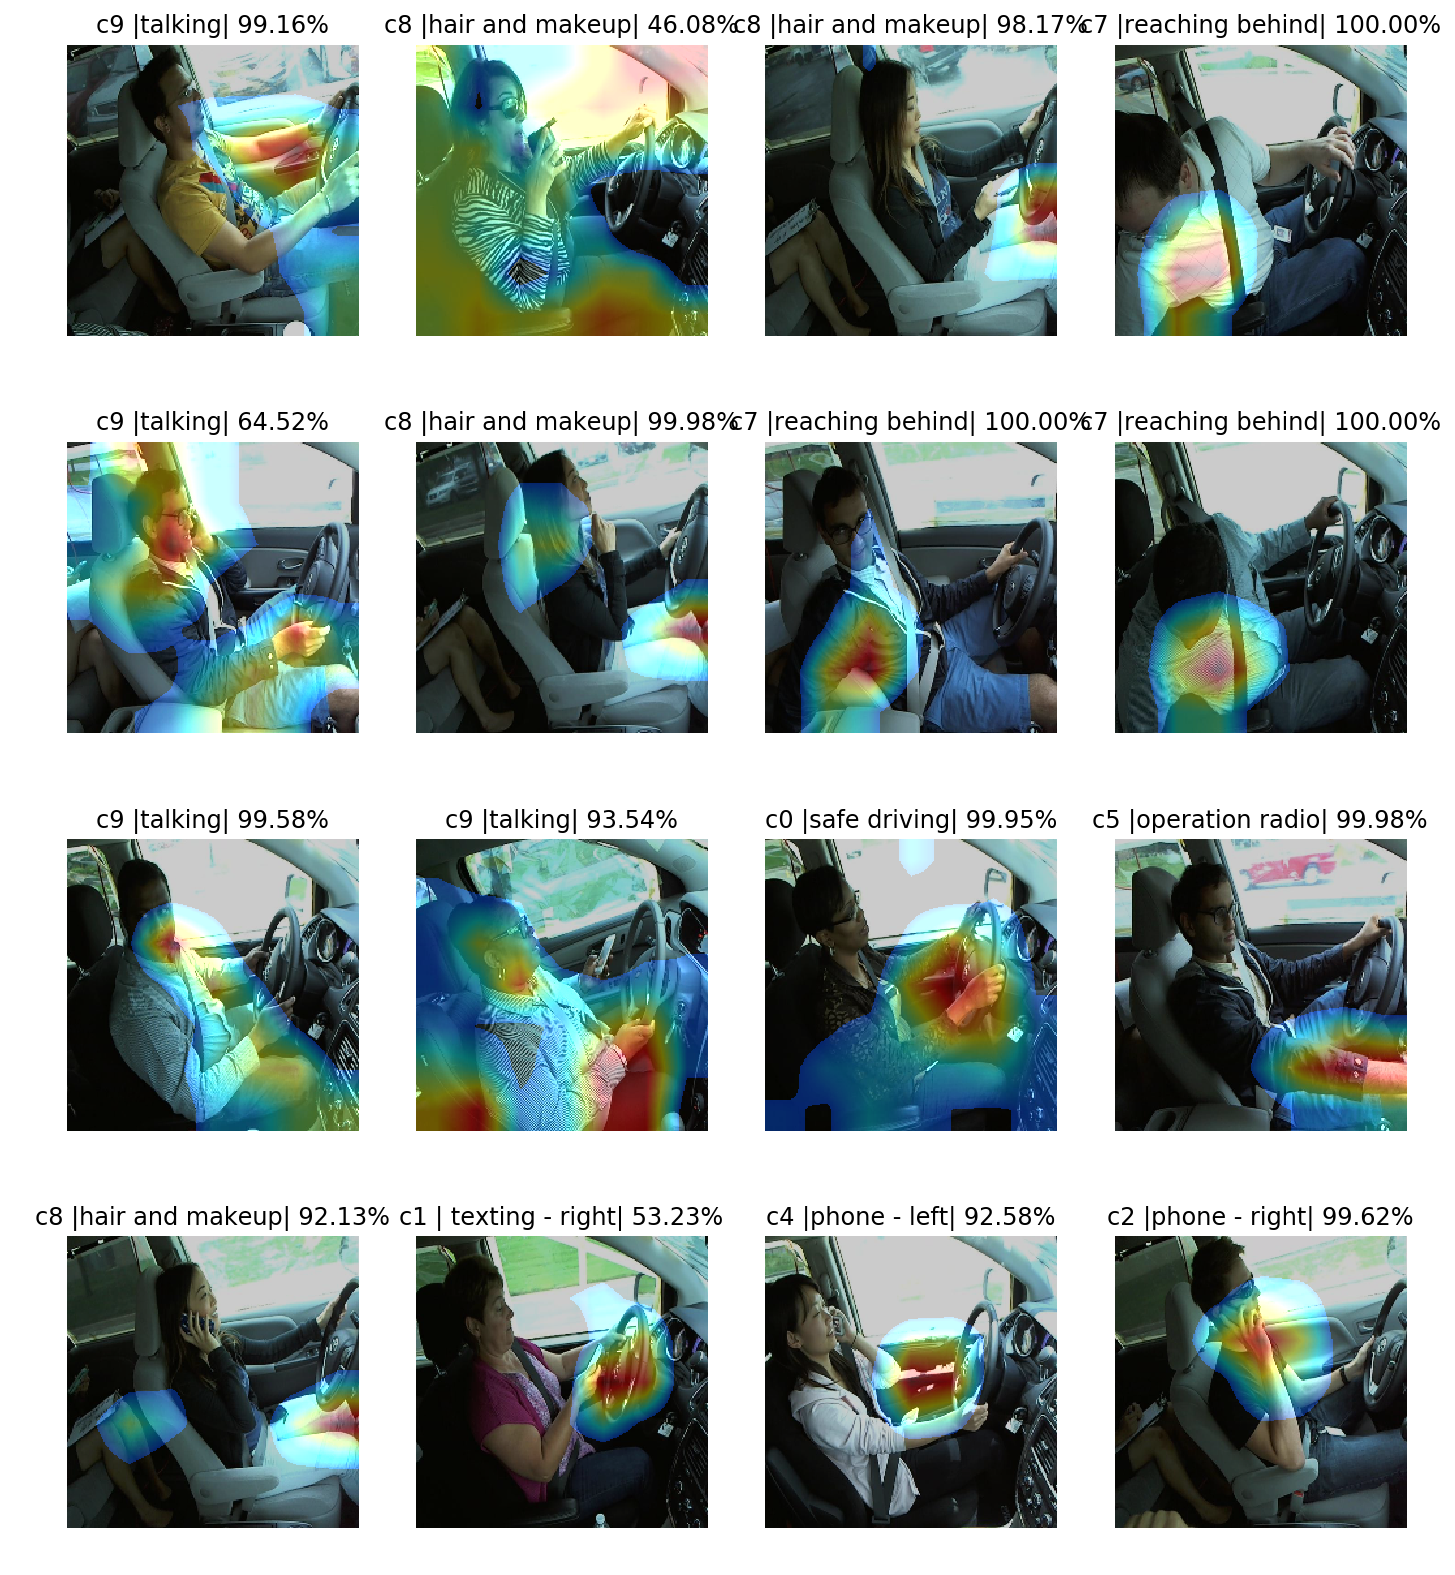

In [26]:
weights = model.layers[176].get_weights()[0]
layer_output = model.layers[172].output
model2 = Model(model.input, [layer_output, model.output])
print("layer_output {0}".format(layer_output))
print("weights shape {0}".format(weights.shape))
show_heatmap_image(model2, weights)

In [27]:
def gen_kaggle_csv(model, X_test,  model_image_size, csv_name):
    y_pred = model.predict(X_test, verbose=1)
    y_pred = y_pred.clip(min=0.005, max=0.995)
    print()
    print(y_pred[:3])

    dir = "/ext/Data/distracted_driver_detection/"

    gen = ImageDataGenerator()
    test_generator = gen.flow_from_directory(dir + "test/", (model_image_size, model_image_size), shuffle=False, 
                                             batch_size=16, class_mode=None)

    l = list()
    for i, fname in enumerate(test_generator.filenames):
        name = fname[fname.rfind('/')+1:]
        l.append( [name, *y_pred[i]] )

    l = np.array(l)
    data = {'img': l[:,0]}
    for i in range(10):
        data["c%d"%i] = l[:,i+1]
    df = pd.DataFrame(data, columns=['img'] + ['c%d'%i for i in range(10)])
    df.head(10)
    df = df.sort_values(by='img')
    df.to_csv(csv_name, index=None, float_format='%.3f')

print("done")

done


In [29]:
print("-------- loading test data")
X_test = list()
dir = os.path.join(basedir, "test/test")
image_files = glob.glob(os.path.join(dir,"*.jpg"))
print("loading {}, image count={}".format(dir, len(image_files)))
count = 0
for image_file in image_files:
    image = cv2.imread(image_file)
    X_test.append(cv2.resize(image, (model_image_size, model_image_size)))
    count += 1
    if count % 2000 == 0: print("loading %d"%count)
X_test = np.array(X_test)
print(X_test.shape)

-------- loading test data
loading /ext/Data/distracted_driver_detection/test/test, image count=79726
loading 2000
loading 4000
loading 6000
loading 8000
loading 10000
loading 12000
loading 14000
loading 16000
loading 18000
loading 20000
loading 22000
loading 24000
loading 26000
loading 28000
loading 30000
loading 32000
loading 34000
loading 36000
loading 38000
loading 40000
loading 42000
loading 44000
loading 46000
loading 48000
loading 50000
loading 52000
loading 54000
loading 56000
loading 58000
loading 60000
loading 62000
loading 64000
loading 66000
loading 68000
loading 70000
loading 72000
loading 74000
loading 76000
loading 78000
(79726, 224, 224, 3)


In [30]:
gen_kaggle_csv(model,  X_test,  model_image_size, 'csv/resnet50-imagenet-finetune140-pred.csv')

79726/79726 [==============================] - 362s      